In [59]:
                                                
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time 


In [60]:
import pandas
import os
import glob
import tensorflow as tf
from keras.applications import ResNet50V2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import keras
import os
import seaborn as sns
import cv2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from keras import regularizers

import seaborn as sns
import glob

In [61]:
main_path = "../input/chest-xray-pneumonia/chest_xray/"
train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")
val_path=os.path.join(main_path,"val")

pneumonia_train_images = glob.glob(train_path+"/PNEUMONIA/*.jpeg")
normal_train_images = glob.glob(train_path+"/NORMAL/*.jpeg")

pneumonia_val_images = glob.glob(val_path+"/PNEUMONIA/*.jpeg")
normal_val_images = glob.glob(val_path+"/NORMAL/*.jpeg")

pneumonia_test_images = glob.glob(test_path+"/PNEUMONIA/*.jpeg")
normal_test_images = glob.glob(test_path+"/NORMAL/*.jpeg")

#CATEGORIES =["NORMAL","PNEUMONIA"]
#img_size=150

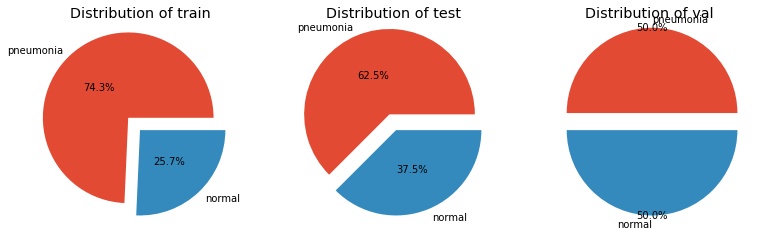

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(13,13))
plt.style.use("ggplot")
axs[0].pie(x=np.array([len(pneumonia_train_images), len(normal_train_images)]), autopct="%.1f%%", explode=[0.2,0], labels=["pneumonia", "normal"], pctdistance=0.5)
axs[0].title.set_text("Distribution of train")


axs[1].pie(x=np.array([len(pneumonia_test_images), len(normal_test_images)]), autopct="%.1f%%", explode=[0.2,0], labels=["pneumonia", "normal"], pctdistance=0.5)
axs[1].title.set_text("Distribution of test ")

axs[2].pie(x=np.array([len(pneumonia_val_images), len(normal_val_images)]), autopct="%.1f%%", explode=[0.2,0], labels=["pneumonia", "normal"], pctdistance=1)
axs[2].title.set_text("Distribution of val ")





### So we can see that there is clear class imbalance in Test and Train data set . Val data set have 50-50 distribution

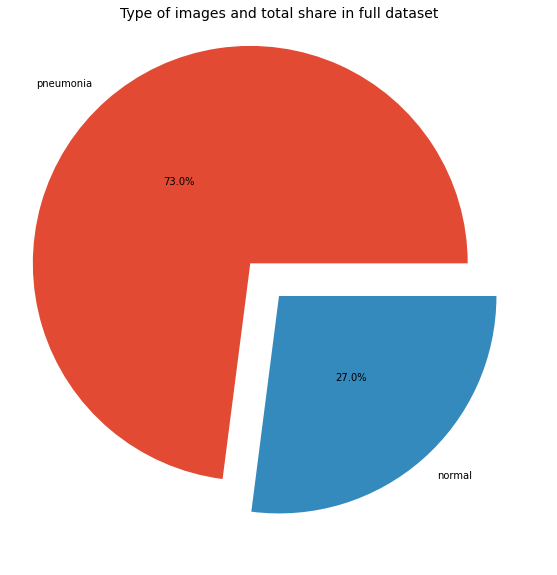

In [63]:

plt.style.use("ggplot")
plt.figure(figsize=(15, 10))
plt.pie(x=np.array([len(pneumonia_train_images)+len(pneumonia_test_images)+len(pneumonia_val_images), len(normal_train_images)+len(normal_test_images)+len(normal_val_images)]), autopct="%.1f%%", explode=[0.2,0], labels=["pneumonia", "normal"], pctdistance=0.5)
plt.title("Type of images and total share in full dataset", fontsize=14);

#### We see that we have an overall imbalanced dataset. Hence, we will be using image augmentation techniques to compensate for this.

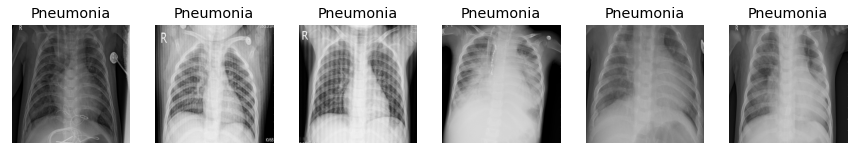

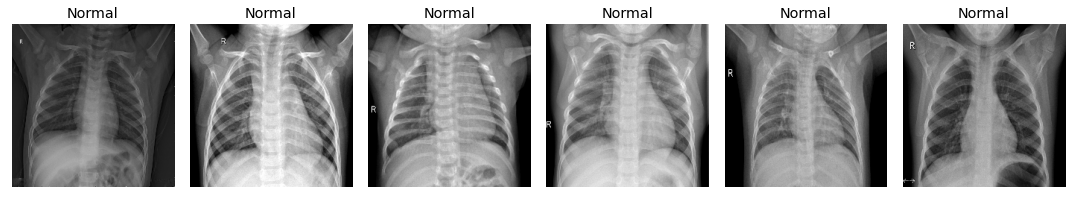

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_train_images[i])
    img = cv2.resize(img, (500,500))
    ax.imshow(img)
    ax.set_title("Pneumonia")
    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()    
plt.show()

In [65]:
train_Pneumonia = len(os.listdir(train_path+'/PNEUMONIA'))
train_Normal =len(os.listdir(train_path+'/NORMAL'))
print(f'len(train_Normal) = {train_Normal},len(train_Pneumonia)={train_Pneumonia}')

len(train_Normal) = 1341,len(train_Pneumonia)=3875


In [66]:
test_Pneumonia = len(os.listdir(test_path+'/PNEUMONIA'))
test_Normal =len(os.listdir(test_path+'/NORMAL'))
print(f'len(test_Normal) = {test_Normal},len(test_Pneumonia)={test_Pneumonia}')

len(test_Normal) = 234,len(test_Pneumonia)=390


In [67]:
val_Pneumonia = len(os.listdir(val_path+'/PNEUMONIA'))
val_Normal =len(os.listdir(val_path+'/NORMAL'))
print(f'len(val_Normal) = {val_Normal},len(val_Pneumonia)={val_Pneumonia}')

len(val_Normal) = 8,len(val_Pneumonia)=8


### As we can see from above Validation data is quite small so we need to add more information to Validation data, so as the reduce the variance in the Validation Accuracy

## Dealing with Data Imbalance

#### Shifting some training data to Validation data¶


In [68]:
from distutils.dir_util import copy_tree

# This will let us transfer our file from input dir to kaggles working/temp
copy_tree(main_path,'temp')

path = './temp/chest_xray'

train_path = os.path.join(path,"train")
test_path=os.path.join(path,"test")
val_path=os.path.join(path,"val")

val_Pneumonia = len(os.listdir(val_path+'/PNEUMONIA'))
val_Normal =len(os.listdir(val_path+'/NORMAL'))
print(f'len(val_Normal) = {val_Normal},len(val_Pneumonia)={val_Pneumonia}')

len(val_Normal) = 200,len(val_Pneumonia)=200


In [69]:
for i in ['/NORMAL/','/PNEUMONIA/']:
    for img in os.listdir(train_path+i)[:191]:
        os.replace(train_path+i+img, val_path+i+img)

In [70]:
val_Pneumonia = len(os.listdir(val_path+'/PNEUMONIA'))
val_Normal =len(os.listdir(val_path+'/NORMAL'))
print(f'len(val_Normal) = {val_Normal},len(val_Pneumonia)={val_Pneumonia}')

len(val_Normal) = 200,len(val_Pneumonia)=200


We saw earlier in this notebook that the data was imbalanced, with more images classified as pneumonia than normal. We will correct for that in this following section. So we will do this data augumentation

Since we got a imbalanced data, lets augment the data and create more images by rotating, zooming and change the width and height. Doing that will help in reducing the bias of model and also generalize it

In our case we are just applying horizontal flip and width shift augmentation


In [71]:
#Deleting variables which will not be used in furture ,to avoid Memory issues
del pneumonia_train_images
del pneumonia_test_images
del pneumonia_val_images
del normal_train_images
del normal_test_images
del normal_val_images

In [72]:
pneumonia_train_img = glob.glob(train_path+"/PNEUMONIA/*.jpeg")
normal_train_img = glob.glob(train_path+"/NORMAL/*.jpeg")

pneumonia_val_img = glob.glob(val_path+"/PNEUMONIA/*.jpeg")
normal_val_img = glob.glob(val_path+"/NORMAL/*.jpeg")

pneumonia_test_img = glob.glob(test_path+"/PNEUMONIA/*.jpeg")
normal_test_img = glob.glob(test_path+"/NORMAL/*.jpeg")


In [73]:
#prepare train dataset for phumonia positive
df_train1 = pd.DataFrame(columns=['image_name','category'])
df_train1['image_name'] = normal_train_img
df_train1['category'] = 1

#prepare validation dataset for phumonia positive
df_val1 = pd.DataFrame(columns=['image_name','category'])
df_val1['image_name'] = normal_val_img
df_val1['category'] = 1

#prepare test dataset for phumonia positive
df_test1 = pd.DataFrame(columns=['image_name','category'])
df_test1['image_name'] = normal_test_img
df_test1['category'] = 1

#prepare train dataset for phumonia negative
df_train2 = pd.DataFrame(columns=['image_name','category'])
df_train2['image_name'] = pneumonia_train_img
df_train2['category'] = 0

#prepare validation dataset for phumonia negative
df_val2 = pd.DataFrame(columns=['image_name','category'])
df_val2['image_name'] = pneumonia_val_img
df_val2['category'] = 0

#prepare test dataset for phumonia negative
df_test2 = pd.DataFrame(columns=['image_name','category'])
df_test2['image_name'] = pneumonia_test_img
df_test2['category'] = 0

In [74]:
#combine both dataset
df_train = df_train1.append(df_train2)
df_val = df_val1.append(df_val2)
df_test = df_test1.append(df_test2)

In [75]:
print('Train dataset shape: %s' %str(df_train.shape))
print('Validation dataset shape: %s' %str(df_val.shape))
print('Test dataset shape: %s' %str(df_test.shape))

Train dataset shape: (4834, 2)
Validation dataset shape: (398, 2)
Test dataset shape: (624, 2)


In [76]:
#facing some memory issue , So removing unsed dataframes 
del df_test2
del df_test1
del df_train1
del df_train2
del df_val1
del df_val2

## Read image files and load

In [77]:
import cv2
img_size = 128
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []
time_s = time.time()

#read train image files
for i,c in zip(df_train.image_name,df_train.category):
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    r_siz = cv2.resize(img, (img_size, img_size))
    x_train.append(r_siz)
    y_train.append(c)
    
#read validation image files
for i,c in zip(df_val.image_name,df_val.category):
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    r_siz = cv2.resize(img, (img_size, img_size))
    x_val.append(r_siz)
    y_val.append(c)
    
#read test image files
for i,c in zip(df_test.image_name,df_test.category):
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    r_siz = cv2.resize(img, (img_size, img_size))
    x_test.append(r_siz)
    y_test.append(c)

print("Time taken: %s seconds" %(time.time() - time_s))

Time taken: 49.058472871780396 seconds


# Normalize and Reshape images

In [78]:
time_s = time.time()

# training images
x_train = np.array(x_train) / 255.
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

# validation images
x_val = np.array(x_val) / 255.
x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

# test images
x_test = np.array(x_test) / 255.
x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

print("Time taken: %s seconds" %(time.time() - time_s))

Time taken: 0.7968511581420898 seconds


# Augment images of training Dataset

#### Augmentation with horizontal_flip 

In [79]:
time_s = time.time()

datagen = ImageDataGenerator(horizontal_flip=True)
x_train_aug1 = np.copy(x_train)
y_train_aug1 = np.copy(y_train)
for i, img in enumerate(x_train):
    tmp = img.reshape(-1, img_size, img_size, 1)
    t_iter = datagen.flow(tmp,  batch_size=1)
    x_train_aug1[i] = next(t_iter)[0]

print("Time taken: %s seconds" %(time.time() - time_s))

Time taken: 1.4256575107574463 seconds


#### Augmentation with width_shift_range=.2

In [80]:
time_s = time.time()

datagen = ImageDataGenerator(width_shift_range=.2)
x_train_aug2 = np.copy(x_train)
y_train_aug2 = np.copy(y_train)
for i, img in enumerate(x_train):
    tmp = img.reshape(-1, img_size, img_size, 1)
    t_iter = datagen.flow(tmp,  batch_size=1)
    x_train_aug2[i] = next(t_iter)[0]

print("Time taken: %s seconds" %(time.time() - time_s))

Time taken: 6.718865633010864 seconds


# Lets print some sample image and its augmentations

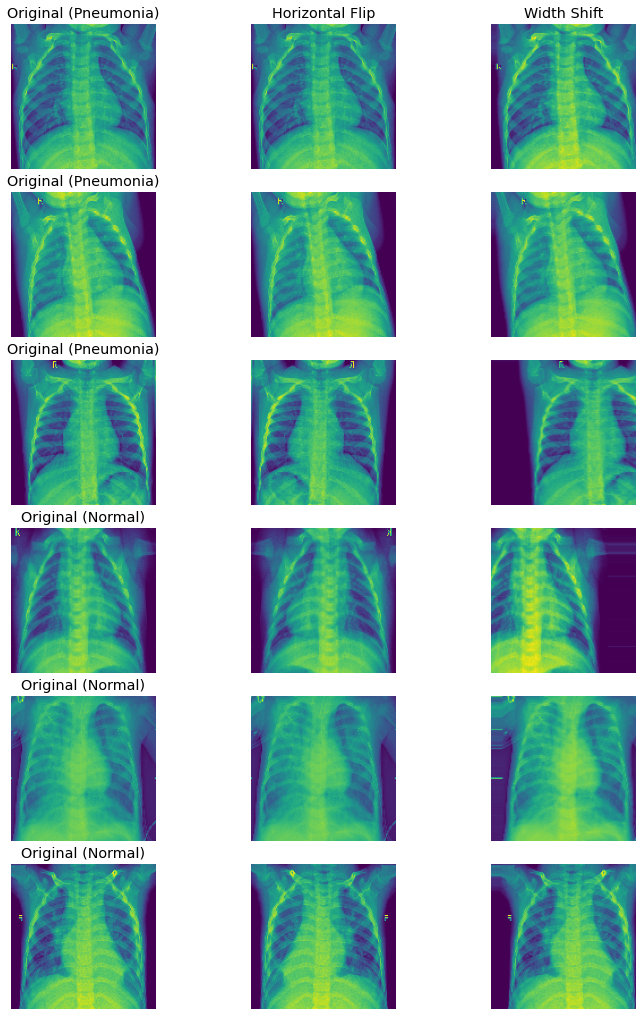

In [81]:
fig, axes = plt.subplots(constrained_layout = True,
                         nrows=6, ncols=3, figsize=(10,14))
index = [0, 165, 350, 4717, 4550, 4822]

for i in range(6):     
    sample_results = []
    sample_results.append(x_train[index[i]])
    sample_results.append(x_train_aug1[index[i]])
    sample_results.append(x_train_aug2[index[i]])
    for s in range(3):
        axes[i][s].imshow(sample_results[s])
        axes[i][s].axis("off")
        if(s == 0):
            t = "Original (Pneumonia)" if y_train[index[i]] == 1 else "Original (Normal)"
            axes[i][s].title.set_text(t)

axes[0][1].title.set_text("Horizontal Flip")
axes[0][2].title.set_text("Width Shift")

#### Combine original and augmented data

In [82]:
x_train_f = np.concatenate([x_train,x_train_aug1,x_train_aug2])
y_train_f = np.concatenate([y_train,y_train_aug1,y_train_aug2])

In [83]:
x_train_f.shape, y_train_f.shape

((14502, 128, 128, 1), (14502,))

In [84]:
print('Train dataset shape: %s' %str(x_train_f.shape))
print('Validation dataset shape: %s' %str(x_val.shape))
print('Test dataset shape: %s' %str(x_test.shape))

Train dataset shape: (14502, 128, 128, 1)
Validation dataset shape: (398, 128, 128, 1)
Test dataset shape: (624, 128, 128, 1)


 # Model Building

### we are using 3 hidden layers only this model has only 2 features and if we increase the hidden layer s then it will increase the complxicity of model that is not needed in this case . So choosing idle configuration that for simple model 2-4 layers is enogh for the model

In [85]:
from keras import backend as K
K.clear_session()
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (128,128,1)),\

tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.001)),\
tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.001)),\
tf.keras.layers.Dropout(.5),\
tf.keras.layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.001)),\
tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

## choosen Dropout layer in middle as if we apply Droupout early then it may be possible that we can loose important information/paterrn which can helpful in good accuracy. So used to apply at middle and performance also increased with the same

## Found by running models 2-3 times that other posistions of 

In [86]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,107,649
Trainable params: 2,107,649
Non-trainable params: 0
______________________________________________

In [87]:


model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.0001),\
loss = 'binary_crossentropy',\
metrics=['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

## Used ADM optimizer as this is very fast and converge rapidly . We have choosed learning rate to 0.0001 as Upon testing with values 0.01 and 0.1, Data was not coverging well . Val dataset performance was not increasing , Accuracy was only 50% and it was not increasing in any ephocs . So best was 0.0001 

In [88]:
time_s = time.time()
epochs = 10
history = model.fit( x=x_train_f, y=y_train_f,shuffle=True,batch_size=32,\
  validation_data=(x_val,y_val),validation_batch_size=16,\
  epochs = epochs
)
t1 = (time.time() - time_s)
print("Time taken to build model: %s seconds" %(t1))

Epoch 1/10
454/454 [==============================] - 3s 6ms/step - loss: 0.8163 - accuracy: 0.7779 - precision: 0.6144 - recall: 0.1612 - val_loss: 0.4830 - val_accuracy: 0.9146 - val_precision: 0.9714 - val_recall: 0.8543
Epoch 2/10
454/454 [==============================] - 2s 5ms/step - loss: 0.4818 - accuracy: 0.8901 - precision: 0.8330 - recall: 0.6646 - val_loss: 0.3081 - val_accuracy: 0.9422 - val_precision: 0.9583 - val_recall: 0.9246
Epoch 3/10
454/454 [==============================] - 2s 5ms/step - loss: 0.3716 - accuracy: 0.9090 - precision: 0.8324 - recall: 0.7607 - val_loss: 0.3679 - val_accuracy: 0.8970 - val_precision: 1.0000 - val_recall: 0.7940
Epoch 4/10
454/454 [==============================] - 3s 6ms/step - loss: 0.3197 - accuracy: 0.9197 - precision: 0.8592 - recall: 0.7815 - val_loss: 0.3151 - val_accuracy: 0.9020 - val_precision: 0.9938 - val_recall: 0.8090
Epoch 5/10
454/454 [==============================] - 2s 5ms/step - loss: 0.2868 - accuracy: 0.9212 - pr

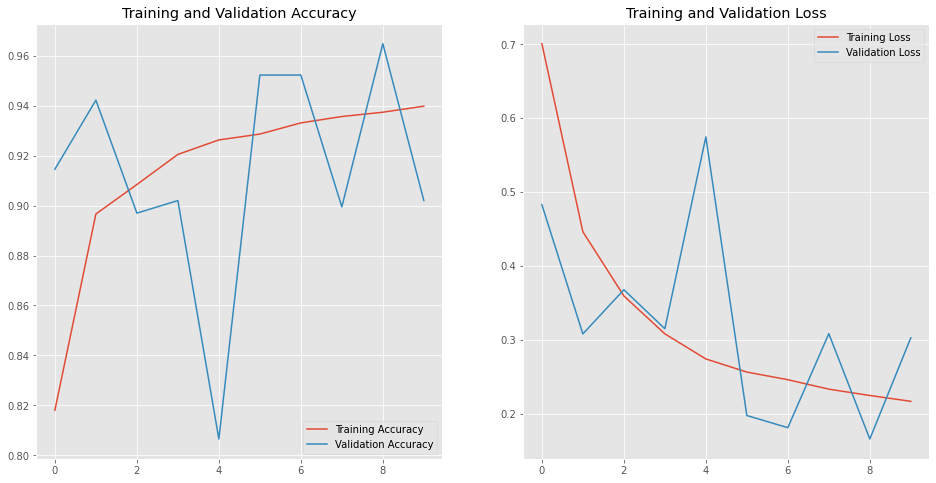

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [90]:
print('Final training accuracy %s' %acc[-1])
print('Final training loss %s' %loss[-1])
print('Final validation accuracy %s' %val_acc[-1])
print('Final validation loss %s' %val_loss[-1])


Final training accuracy 0.9398013949394226
Final training loss 0.21692468225955963
Final validation accuracy 0.9020100235939026
Final validation loss 0.3028387427330017


# Model Prediction and Evaluation

In [91]:
pred = model.predict(x_test, batch_size=10)
y_pred = np.copy(y_test)
for i,x in enumerate(pred):
    y_pred[i] = 1 if x[0] >= 0.5 else 0

In [92]:
score = model.evaluate(x_test, y_test) 
ac1 = score[1]
pc1 = score[2]
re1 = score[3]
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])

20/20 [==============================] - 0s 4ms/step - loss: 1.3079 - accuracy: 0.7147 - precision: 0.9667 - recall: 0.2479
Test loss: 1.3078868389129639
Test accuracy: 0.7147436141967773
Test precision: 0.9666666388511658
Test recall: 0.24786324799060822


In [93]:
sv_cmatrix = pd.DataFrame({'test': y_test,
                          'pred': y_pred})

#Confusion matrix
print()
print()
print('*******Confusion Matrix******')
pd.crosstab(sv_cmatrix['test'], sv_cmatrix['pred'])



*******Confusion Matrix******


pred,0,1
test,,
0,388,2
1,176,58


### Print Misclassified Sample

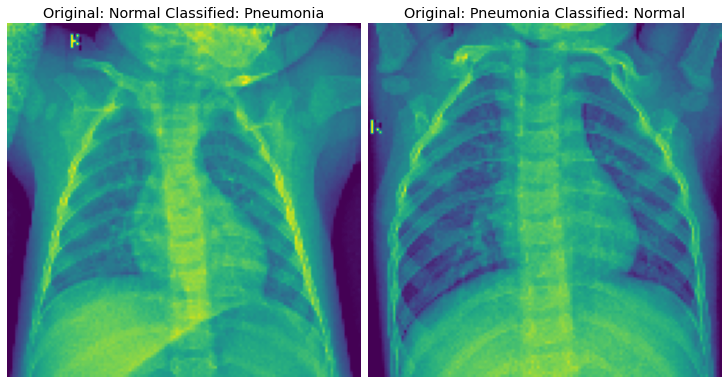

In [94]:
#Printing misclassified images

fig, axes = plt.subplots(constrained_layout = True,
                         nrows=1, ncols=2, figsize=(10,14))
cl = 1
for i,c in enumerate(y_test):
    if (c != pred[i] and c == cl):
        axes[cl].imshow(x_train[i])
        axes[cl].axis("off")
        cl -= 1
    elif cl == -1:
        break

axes[0].title.set_text("Original: Normal Classified: Pneumonia")
axes[1].title.set_text("Original: Pneumonia Classified: Normal")

# Hyperparameter Tuning

### Change batch size

In [95]:
K.clear_session()
model1 = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (128,128,1)),\
tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.1)),\
tf.keras.layers.Dense(64, activation=tf.nn.relu,kernel_regularizer=regularizers.l2(0.1)),\
tf.keras.layers.Dropout(.2),\
tf.keras.layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.1)),\
tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [96]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,107,649
Trainable params: 2,107,649
Non-trainable params: 0
______________________________________________

In [97]:
model1.compile(optimizer = tf.optimizers.Adam(learning_rate=0.0001),\
loss = 'binary_crossentropy',\
metrics=['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [98]:
# changed batch size to 128
time_s = time.time()
epochs = 15
history1 = model1.fit( x=x_train_f, y=y_train_f,shuffle=True,batch_size=64,\
  validation_data=(x_val,y_val),validation_batch_size=16,\
  epochs = epochs
)
t2 = (time.time() - time_s)
print("Time taken to build model: %s seconds" %(t2))

Epoch 1/15
227/227 [==============================] - 3s 8ms/step - loss: 25.9992 - accuracy: 0.8058 - precision: 0.8176 - recall: 0.1978 - val_loss: 10.5703 - val_accuracy: 0.7035 - val_precision: 1.0000 - val_recall: 0.4070
Epoch 2/15
227/227 [==============================] - 1s 6ms/step - loss: 9.2858 - accuracy: 0.8724 - precision: 0.8893 - recall: 0.5324 - val_loss: 6.9996 - val_accuracy: 0.8116 - val_precision: 1.0000 - val_recall: 0.6231
Epoch 3/15
227/227 [==============================] - 1s 6ms/step - loss: 6.3918 - accuracy: 0.8719 - precision: 0.8635 - recall: 0.5487 - val_loss: 4.9440 - val_accuracy: 0.8995 - val_precision: 0.9818 - val_recall: 0.8141
Epoch 4/15
227/227 [==============================] - 1s 6ms/step - loss: 4.5637 - accuracy: 0.8817 - precision: 0.8875 - recall: 0.5795 - val_loss: 3.5700 - val_accuracy: 0.8894 - val_precision: 1.0000 - val_recall: 0.7789
Epoch 5/15
227/227 [==============================] - 1s 6ms/step - loss: 3.2810 - accuracy: 0.8840 - 

In [99]:
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']

loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

print('Final training accuracy %s' %acc[-1])
print('Final training loss %s' %loss[-1])
print('Final validation accuracy %s' %val_acc[-1])
print('Final validation loss %s' %val_loss[-1])

Final training accuracy 0.9398013949394226
Final training loss 0.21692468225955963
Final validation accuracy 0.9020100235939026
Final validation loss 0.3028387427330017


In [100]:
pred1 = model1.predict(x_test, batch_size=10)
y_pred1 = np.copy(y_test)
for i,x in enumerate(pred1):
    y_pred1[i] = 1 if x[0] >= 0.5 else 0

In [101]:
score1 = model1.evaluate(x_test, y_test) 
ac2 = score1[1]
pc2 = score1[2]
re2 = score1[3]
print('Test loss:', score1[0]) 
print('Test accuracy:', score1[1])
print('Test precision:', score1[2])
print('Test recall:', score1[3])

20/20 [==============================] - 0s 4ms/step - loss: 0.7262 - accuracy: 0.7404 - precision: 0.8913 - recall: 0.3504
Test loss: 0.7261543869972229
Test accuracy: 0.7403846383094788
Test precision: 0.8913043737411499
Test recall: 0.3504273593425751


In [102]:
sv_cmatrix1 = pd.DataFrame({'test': y_test,
                          'pred': y_pred1})

#Confusion matrix
print()
print()
print('*******Confusion Matrix******')
pd.crosstab(sv_cmatrix1['test'], sv_cmatrix1['pred'])



*******Confusion Matrix******


pred,0,1
test,,
0,380,10
1,152,82


### Change dropout layer

In [103]:
K.clear_session()
model2 = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (128,128,1)),\
tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.1)),\
tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.1)),\
tf.keras.layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.1)),\
tf.keras.layers.Dropout(.2),\
tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [104]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,107,649
Trainable params: 2,107,649
Non-trainable params: 0
______________________________________________

In [105]:
model2.compile(optimizer = tf.optimizers.Adam(learning_rate=0.0001),\
loss = 'binary_crossentropy',\
metrics=['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [106]:
time_s = time.time()
epochs = 10
history2 = model2.fit( x=x_train_f, y=y_train_f,shuffle=True,batch_size=32,\
  validation_data=(x_val,y_val),validation_batch_size=16,\
  epochs = epochs
)
t3 = (time.time() - time_s)
print("Time taken to build model: %s seconds" %(t3))

Epoch 1/10
454/454 [==============================] - 4s 7ms/step - loss: 21.5782 - accuracy: 0.8036 - precision: 0.6990 - recall: 0.2409 - val_loss: 7.2899 - val_accuracy: 0.7663 - val_precision: 1.0000 - val_recall: 0.5327
Epoch 2/10
454/454 [==============================] - 2s 5ms/step - loss: 6.1444 - accuracy: 0.8700 - precision: 0.8375 - recall: 0.5629 - val_loss: 4.0992 - val_accuracy: 0.6307 - val_precision: 1.0000 - val_recall: 0.2613
Epoch 3/10
454/454 [==============================] - 3s 6ms/step - loss: 3.2690 - accuracy: 0.8686 - precision: 0.8438 - recall: 0.5607 - val_loss: 2.1431 - val_accuracy: 0.7965 - val_precision: 1.0000 - val_recall: 0.5930
Epoch 4/10
454/454 [==============================] - 2s 5ms/step - loss: 1.8051 - accuracy: 0.8807 - precision: 0.8710 - recall: 0.5881 - val_loss: 1.2110 - val_accuracy: 0.8945 - val_precision: 0.9876 - val_recall: 0.7990
Epoch 5/10
454/454 [==============================] - 2s 5ms/step - loss: 1.1001 - accuracy: 0.8838 - p

In [107]:
acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']

loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

print('Final training accuracy %s' %acc2[-1])
print('Final training loss %s' %loss2[-1])
print('Final validation accuracy %s' %val_acc2[-1])
print('Final validation loss %s' %val_loss2[-1])

Final training accuracy 0.9398013949394226
Final training loss 0.21692468225955963
Final validation accuracy 0.9020100235939026
Final validation loss 0.3028387427330017


In [108]:
pred2 = model2.predict(x_test, batch_size=10)
y_pred2 = np.copy(y_test)
for i,x in enumerate(pred2):
    y_pred2[i] = 1 if x[0] >= 0.5 else 0

In [109]:
score2 = model2.evaluate(x_test, y_test) 
ac3 = score2[1]
pc3 = score2[2]
re3 = score2[3]
print('Test loss:', score2[0]) 
print('Test accuracy:', score2[1])
print('Test precision:', score2[2])
print('Test recall:', score2[3])

20/20 [==============================] - 0s 4ms/step - loss: 1.0446 - accuracy: 0.6394 - precision: 1.0000 - recall: 0.0385       
Test loss: 1.0446138381958008
Test accuracy: 0.6394230723381042
Test precision: 1.0
Test recall: 0.03846153989434242


In [110]:
sv_cmatrix2 = pd.DataFrame({'test': y_test,
                          'pred': y_pred2})

#Confusion matrix
print()
print()
print('*******Confusion Matrix******')
pd.crosstab(sv_cmatrix2['test'], sv_cmatrix2['pred'])



*******Confusion Matrix******


pred,0,1
test,,
0,390,0
1,225,9


# Comparison between models

In [111]:
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'Build Time'])
results.loc[0] = ['3 Layer Fully Connected',ac1,pc1,re1,t1]
results.loc[1] = ['With Changed Batch Size',ac2,pc2,re2,t2]
results.loc[2] = ['With Changed Dropout Layer',ac3,pc3,re3,t3]
results

,Model,Accuracy,Precision,Recall,Build Time
0,3 Layer Fully Connected,0.714744,0.966667,0.247863,25.833027
1,With Changed Batch Size,0.740385,0.891304,0.350427,24.836586
2,With Changed Dropout Layer,0.639423,1.000000,0.038462,25.780628


# Above result shows doubling batch size higher improved build time, Model has more accuracy then others